In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
tf.config.experimental.set_memory_growth(gpu[1], True)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('df_train_clean_lemma.csv')
df.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason hastag earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive hastag wildfire evacuatio...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby hastag alaska smoke hastag wil...


In [3]:
tokenize = tf.keras.preprocessing.text.Tokenizer()

In [4]:
df.text_clean = df.text_clean.astype(str)

In [5]:
tokenize.fit_on_texts(df.text_clean)
df['text_tokenize'] = tokenize.texts_to_sequences(df.text_clean)
df.head()

,text,target,text_clean,text_tokenize
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason hastag earthquake allah forgive,"[3675, 422, 1, 168, 1251, 1952]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[114, 3, 157, 503, 5525, 5526, 950]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1369, 443, 1706, 316, 5527, 286, 180, 1706, 3..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive hastag wildfire evacuatio...,"[2307, 5, 2308, 1, 68, 180, 287, 33]"
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby hastag alaska smoke hastag wil...,"[174, 120, 5528, 1, 1707, 165, 1, 68, 2309, 105]"


In [6]:
padded = tf.keras.preprocessing.sequence.pad_sequences(df.text_tokenize, padding="post")

In [7]:
#tensor_df = tf.data.Dataset.from_tensor_slices((padded, df.target.values))

In [8]:
y = df['target']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(padded, y, test_size=0.30, random_state=42, stratify = y)

train_data = tf.data.Dataset.from_tensor_slices((X_train_t, y_train_t))
test_data = tf.data.Dataset.from_tensor_slices((X_test_t, y_test_t))

train_data = train_data.shuffle(len(train_data)).batch(16)
test_data = test_data.shuffle(len(test_data)).batch(16)

In [9]:
#TAKE_SIZE = int(0.7*df.shape[0])
#BATCH_SIZE = 16

#train_data = tensor_df.take(TAKE_SIZE).shuffle(TAKE_SIZE)
#train_data = train_data.batch(BATCH_SIZE)

#test_data = tensor_df.skip(TAKE_SIZE).shuffle(df.shape[0]-TAKE_SIZE)
#test_data = test_data.batch(BATCH_SIZE)

In [10]:
for train, target in train_data.take(1):
    print(train)
    print(target)

tf.Tensor(
[[ 3103   609    14   188   105    19     8    30     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [14576    51  1989  1535  1856   966    73     1 14577     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 9352  9353  9354    83  1904  1482    56  9355     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  151    20   162   553   676   231    30     3     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    1   440  1290 10559  4490     1   818  2365   117    81 10560  1060
      1 10561     6     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  249   526   138    99   192   108   301    27     0     0     0     0
      0     0     0     0     0     0   

In [11]:
vocab_size=len(tokenize.word_index)
vocab_size

15998

In [19]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[train.shape[1]]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.LSTM(32, return_sequences=False),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.3) ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           2047872   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 32)            18560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,075,297
Trainable params: 2,075,297
Non-trainable params: 0
____________________________________________

In [21]:
initial_learning_rate = 0.00005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=250,
    decay_rate=0.96,
    staircase=True)

optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

In [22]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [23]:
class_weight = {
    0:1,
    1:1.33,
}

In [24]:
history = model.fit(train_data, epochs=20, validation_data=test_data,class_weight=class_weight)

Epoch 1/20
334/334 [==============================] - 12s 25ms/step - loss: 27.3290 - binary_accuracy: 0.5367 - val_loss: 25.3879 - val_binary_accuracy: 0.5705
Epoch 2/20
334/334 [==============================] - 7s 21ms/step - loss: 24.9125 - binary_accuracy: 0.5500 - val_loss: 23.1371 - val_binary_accuracy: 0.5701
Epoch 3/20
334/334 [==============================] - 7s 21ms/step - loss: 22.7088 - binary_accuracy: 0.5696 - val_loss: 21.0877 - val_binary_accuracy: 0.5744
Epoch 4/20
334/334 [==============================] - 7s 22ms/step - loss: 20.7160 - binary_accuracy: 0.5912 - val_loss: 19.1813 - val_binary_accuracy: 0.6388
Epoch 5/20
334/334 [==============================] - 7s 21ms/step - loss: 18.8121 - binary_accuracy: 0.7337 - val_loss: 17.4376 - val_binary_accuracy: 0.7968
Epoch 6/20
334/334 [==============================] - 7s 22ms/step - loss: 17.0717 - binary_accuracy: 0.8720 - val_loss: 15.9108 - val_binary_accuracy: 0.7815
Epoch 7/20
334/334 [=========================

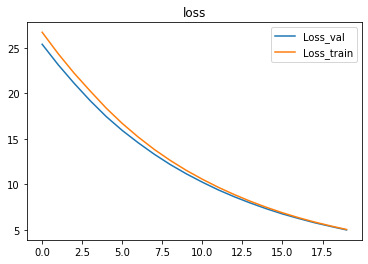

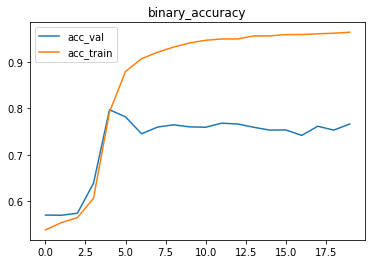

In [35]:
loss_curve = history.history["loss"]
loss_val = history.history["val_loss"]
acc_curve = history.history["binary_accuracy"]
acc_val = history.history["val_binary_accuracy"]

plt.plot(loss_val,label="Loss_val")
plt.plot(loss_curve,label="Loss_train")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(acc_val, label="acc_val" )
plt.plot(acc_curve, label="acc_train" )
plt.legend()
plt.title("binary_accuracy")
plt.show()

[3, 2, 1]